# Analyze vibrational entropy, as computed by CREST / GFN2 across a large molecular test set

This notebook is intended to be used in JupyterLab. YMMV

In [1]:
from __future__ import print_function

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")

from scipy import constants

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import sklearn
from sklearn.metrics import mean_absolute_error

# also use a mean absolute percent error (MAPE)
# From https://stats.stackexchange.com/a/294069/42723
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# And a wrapper for statsmodel style formulas
# Adapted from https://stackoverflow.com/a/59100482/131896
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin

class SMFormulaWrapper(BaseEstimator, RegressorMixin):
    """ A sklearn-style wrapper for formula-based statsmodels regressors """
    def __init__(self, model_class, formula):
        self.model_class = model_class
        self.formula = formula
    def fit(self, X, y=None):
        self.model_ = self.model_class(self.formula, data=X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        return self.results_.predict(X)

We'll read in the combined CSV, including subset name, filename, SMILES, computed entropies, and a variety of descriptors generated by RDKit

In [2]:
df = pd.read_csv("total-entropy.csv")
# drop inf and nan (i.e. some molecules from COD don't have Gasteiger charges)
df.replace([np.inf, -np.inf], np.nan)
df.dropna(inplace=True)
# some vibrational jobs failed, so drop if VibEntropy == 0
df = df[df.VibEntropy != 0]
print(len(df.index))
# 115599 molecules left
#  (technically we should check to make sure all the SMILES are unique!)

115599


In [3]:
# what do we have left?
print(df.columns)
df = df.astype({"NumAtoms": int, "NumBonds": int, "NumRotors": int, "NumMethyl": int, "NumAmine": int, "NumHydroxyl": int, "HDonors": int, "HAcceptors": int, "RingCount": int, "NumAromaticRings": int})
df.describe()

Index(['Category', 'File', 'SMILES', 'ConfEntropy', 'VibEntropy', 'RotEntropy',
       'TransEntropy', 'NumAtoms', 'NumBonds', 'ExactMolWt', 'Volume',
       'NumRotorsStrict', 'NumRotors', 'NumMethyl', 'NumAmine', 'NumHydroxyl',
       'HDonors', 'HAcceptors', 'RingCount', 'NumAromaticRings',
       'MaxAbsPartialChg', 'MinAbsPartialChg', 'MaxPartialChg',
       'MinPartialChg', 'TPSA', 'LabuteASA', 'MolMR', 'MolLogP', 'EState_VSA1',
       'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5',
       'HallKierAlpha', 'BertzCT', 'BalabanJ', 'Ipc', 'Kappa1', 'Kappa2',
       'Kappa3', 'FractionCSP3', 'NumBridgeheadAtoms', 'NumSpiroAtoms',
       'Asphericity', 'Eccentricity', 'InertialShapeFactor',
       'RadiusOfGyration', 'SpherocityIndex', 'ConfUnder1', 'ConfUnder2',
       'ConfUnder3', 'ConfUnder4', 'ConfUnder5', 'ConfUnder6', 'ECFP4',
       'ECFP6'],
      dtype='object')


,ConfEntropy,VibEntropy,RotEntropy,TransEntropy,NumAtoms,NumBonds,ExactMolWt,Volume,NumRotorsStrict,NumRotors,...,Eccentricity,InertialShapeFactor,RadiusOfGyration,SpherocityIndex,ConfUnder1,ConfUnder2,ConfUnder3,ConfUnder4,ConfUnder5,ConfUnder6
count,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,...,115599.000000,115599.000000,115599.000000,1.155990e+05,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000,115599.000000
mean,34.600737,396.587555,149.397586,182.867627,28.846954,31.686105,403.960759,312.795836,4.585844,5.305349,...,0.939662,0.000980,4.216079,1.815609e-01,6.963633,18.400851,35.212779,56.374510,80.246923,104.314319
std,12.579259,144.674773,8.564845,4.143806,9.175250,10.688507,124.997746,94.665169,2.663472,3.052690,...,0.066122,0.002114,0.976017,1.498155e-01,11.066574,32.883641,64.505961,103.662286,146.573767,188.945147
min,0.004000,24.589368,95.997696,158.891584,4.000000,3.000000,56.026215,50.192000,0.000000,0.000000,...,0.098074,0.000012,1.231888,3.065851e-13,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,26.387000,288.953316,144.527912,180.334584,22.000000,24.000000,313.073537,243.912000,3.000000,3.000000,...,0.912651,0.000315,3.533319,7.594415e-02,2.000000,3.000000,4.000000,6.000000,7.000000,8.000000
50%,36.106000,405.266424,151.004744,183.861696,30.000000,33.000000,416.107578,322.304000,4.000000,5.000000,...,0.961570,0.000554,4.156412,1.438170e-01,4.000000,8.000000,14.000000,20.000000,27.000000,33.000000
75%,43.851000,483.881692,154.966992,185.543664,34.000000,38.000000,476.114814,368.372000,6.000000,7.000000,...,0.987186,0.001016,4.830287,2.476433e-01,8.000000,20.000000,39.000000,62.000000,89.000000,117.000000
max,69.453000,1689.051512,188.941072,203.702224,128.000000,168.000000,2039.240573,1132.392000,20.000000,20.000000,...,0.999999,0.235738,12.050900,9.944582e-01,427.000000,981.000000,1469.000000,2244.000000,2997.000000,4137.000000


The goal is to understand how the computed **vibrational** entropies change with molecular structure.

Since larger molecules likely have more vibrational modes (3N-6) and lower-energy modes (i.e., they're bigger) - let's start with simple models comparing ExactMolt and NumAtoms 

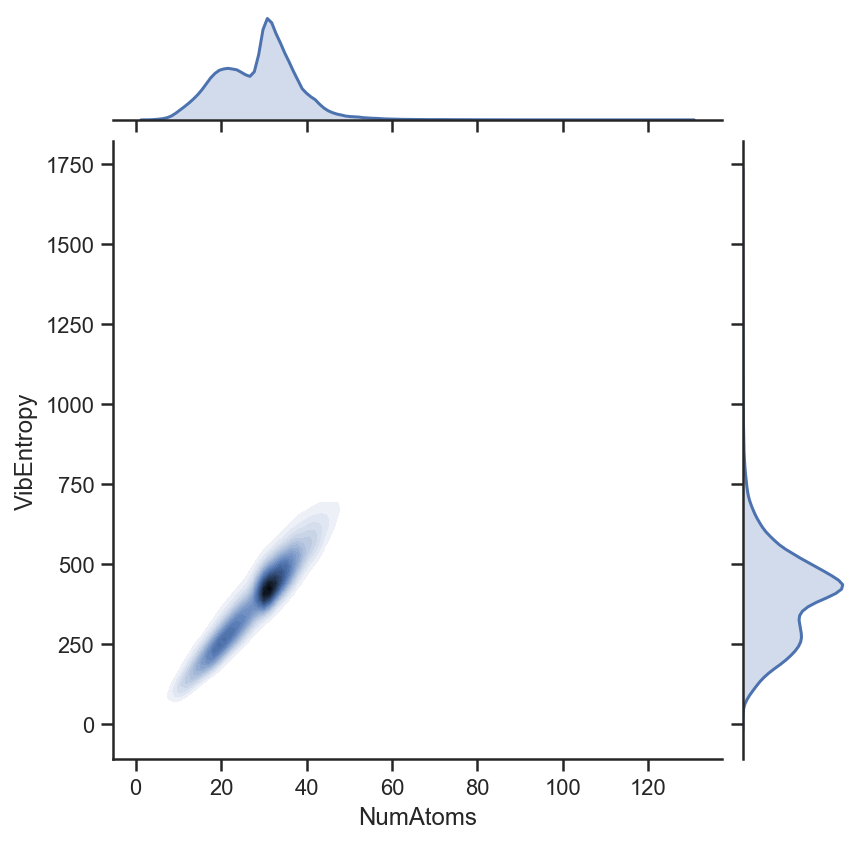

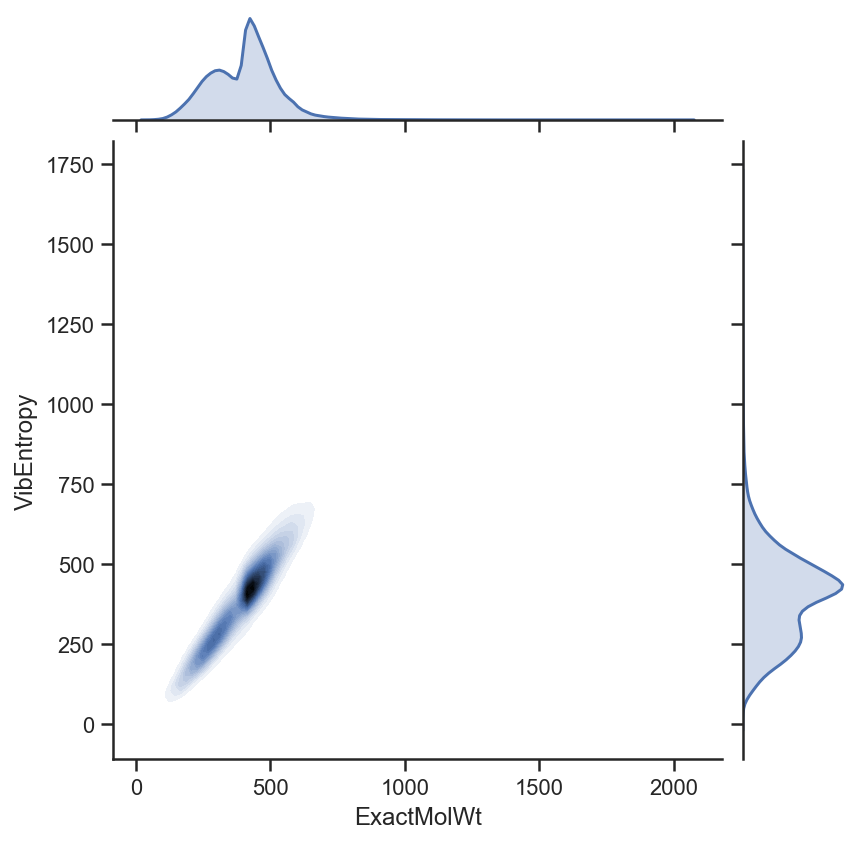

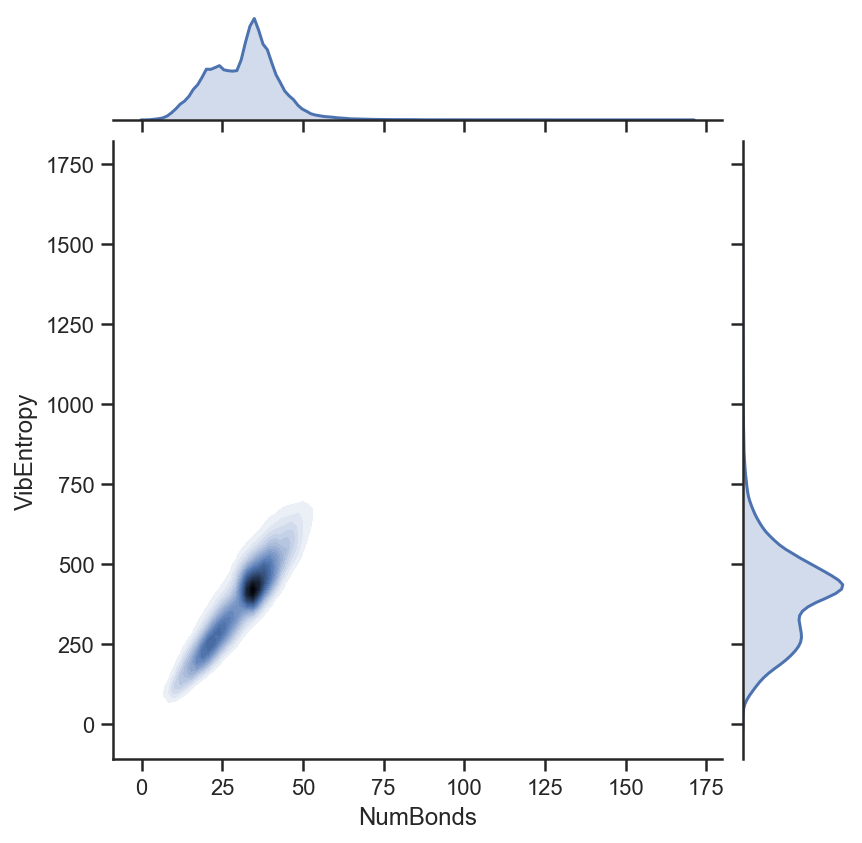

In [4]:
sns.jointplot(x="NumAtoms", y="VibEntropy", data=df, kind='kde', n_levels=30, shade_lowest=False)
sns.jointplot(x="ExactMolWt", y="VibEntropy", data=df, kind='kde', n_levels=30, shade_lowest=False)
sns.jointplot(x="NumBonds", y="VibEntropy", data=df, kind='kde', n_levels=30, shade_lowest=False)

Text(336.9714285714286, 0.5, 'GFN2 Vibrational Entropy J/mol•K')

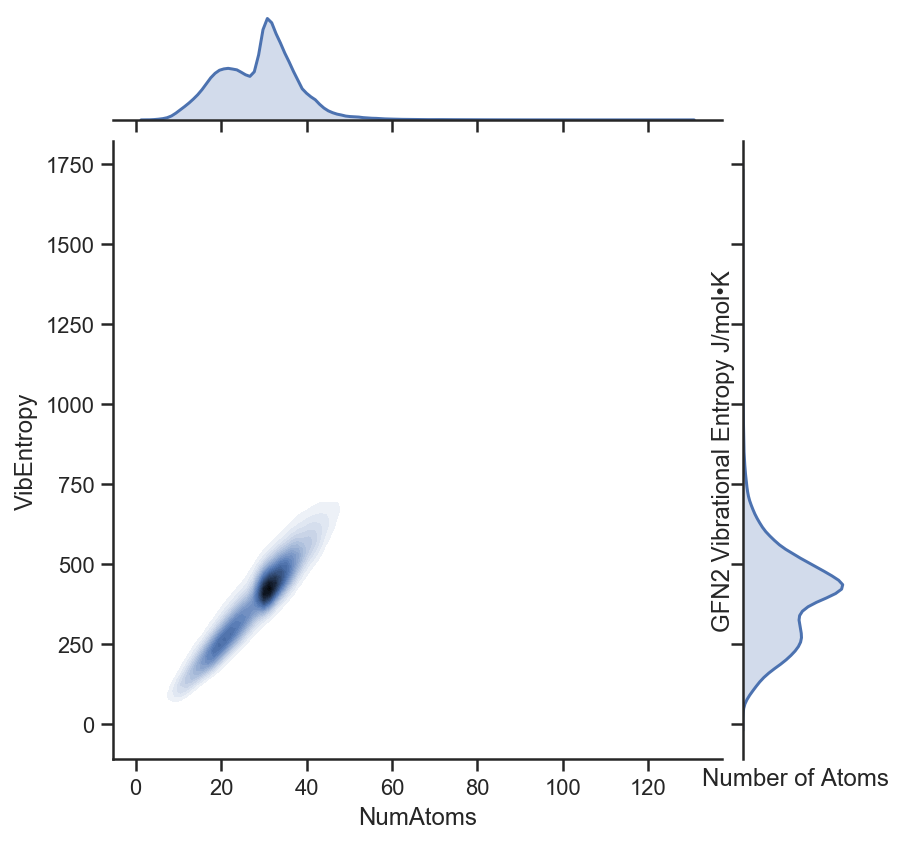

In [5]:
sns.jointplot(x="NumAtoms", y="VibEntropy", data=df, kind='kde', n_levels=30, shade_lowest=False)
plt.xlabel('Number of Atoms')
plt.ylabel('GFN2 Vibrational Entropy J/mol•K')

In [4]:
lm1 = ols('VibEntropy~NumAtoms', data=df).fit()
print('mean absolute error (NumAtoms):', mean_absolute_error(df['VibEntropy'], lm1.fittedvalues))
print(lm1.params)

lm2 = ols('VibEntropy~ExactMolWt', data=df).fit()
print('mean absolute error (ExactMolWt):', mean_absolute_error(df['VibEntropy'], lm2.fittedvalues))

lm3 = ols('VibEntropy~NumBonds', data=df).fit()
print('mean absolute error (NumBonds):', mean_absolute_error(df['VibEntropy'], lm3.fittedvalues))

mean absolute error (NumAtoms): 34.848993854109956
Intercept   -32.482888
NumAtoms     14.874030
dtype: float64
mean absolute error (ExactMolWt): 34.662497907550126
mean absolute error (NumBonds): 43.76748172170672


In [7]:
lm4 = ols('VibEntropy~ExactMolWt+NumAtoms+NumBonds', data=df).fit()
print('mean absolute error (Combined):', mean_absolute_error(df['VibEntropy'], lm4.fittedvalues))

mean absolute error (Combined): 22.19702741327644


Nice, that's a solid decrease in error - now ~22 J/mol•K. At 300K, that's an error of ~1.5 kcal/mol - let's see if we can do better with QSAR

In [8]:
formula = 'VibEntropy~NumAtoms+NumBonds+ExactMolWt+Volume+NumRotors+NumMethyl+NumAmine+NumHydroxyl+HDonors+HAcceptors+RingCount+NumAromaticRings+TPSA+LabuteASA+MolMR+MolLogP+HallKierAlpha+BertzCT+BalabanJ+Ipc+Kappa1+Kappa2+Kappa3+FractionCSP3+NumSpiroAtoms+NumBridgeheadAtoms+Asphericity+Eccentricity+InertialShapeFactor+RadiusOfGyration+SpherocityIndex'

In [9]:
# we're going to use LASSO regularization to drop some values
max_mae = 100.0
best_alpha = 0
for a in range(100):
    lm = ols(formula, df).fit_regularized(alpha=float(a)/100.0)
    mae = mean_absolute_error(df['VibEntropy'], lm.fittedvalues)
    if mae < max_mae:
        best_alpha = float(a)/100.0
        max_mae = mae
        print('best so far', best_alpha, max_mae)

lm = ols(formula,df).fit_regularized(alpha=best_alpha)
print(lm.params)

best so far 0.0 20.778554617270196
best so far 0.02 20.772718287439634
best so far 0.03 20.7272399501087
best so far 0.04 20.683214412627652
best so far 0.05 20.638500077679147
best so far 0.06 20.610903293454136
best so far 0.07 20.567037715522986
best so far 0.08 20.50641557339332
best so far 0.1 20.48145459933463
best so far 0.11 20.43921036769086
best so far 0.14 20.401516710166057
best so far 0.17 20.378939826222986
best so far 0.18 20.341594213321603
best so far 0.21 20.32308004296306
best so far 0.22 20.287837335929197
best so far 0.23 20.2533992387499
best so far 0.24 20.219626620010636
best so far 0.25 20.186605799794048
best so far 0.26 20.154380232507158
best so far 0.27 20.12296279713326
best so far 0.28 20.092434918712552
best so far 0.29 20.062708517438328
best so far 0.3 20.03385466843076
best so far 0.31 20.005883543601687
best so far 0.32 19.978744967912753
best so far 0.33 19.95251761309092
best so far 0.34 19.925395427132433
best so far 0.35 19.898461859030466
best s

It turns out that a bunch of these are cross-correlated, but LASSO drops the ExactMolWt and NumBonds in favor of NumAtoms, and picks up NumMethyl and RingCount (i.e., more rings = less entropy). What follows is a hand-tuned model after selecting from the factors with large scores from LASSO:

In [10]:
lm5 = ols('VibEntropy~NumAtoms+NumMethyl+RingCount', data=df).fit()
print(lm5.summary())
print('mean absolute error (Combined):', mean_absolute_error(df['VibEntropy'], lm5.fittedvalues))
print('mean absolute % error (Combined):', mean_absolute_percentage_error(df['VibEntropy'], lm5.fittedvalues))

                            OLS Regression Results                            
Dep. Variable:             VibEntropy   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 1.241e+06
Date:                Sat, 28 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:12:48   Log-Likelihood:            -5.3662e+05
No. Observations:              115599   AIC:                         1.073e+06
Df Residuals:                  115595   BIC:                         1.073e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -52.1826      0.247   -210.858      0.0

So we've dropped the error to ~17 J/mol•K, about half our original error - corresponding to ~1.2 kcal/mol at 300K. 

We have two holdout sets. One is a pool of ~9000 cyclic tetrapeptides (`data/peptides-entropy.csv`), the other is a pool of ~20k molecules from ZINC run on a different resource (`data/holdout-zinc.csv`).

Let's compare how well our model does on these sets:

In [11]:
# a set of cyclic peptides
df2 = pd.read_csv("data/peptides-entropy.csv")
# drop inf and nan (i.e. some molecules from COD don't have Gasteiger charges)
df2.replace([np.inf, -np.inf], np.nan)
df2.dropna(inplace=True)
print(len(df2.index))

8663


In [12]:
# okay, how does our model handle this new set of molecules
print(mean_absolute_error(df2['VibEntropy'], lm5.predict(df2)))
print(mean_absolute_percentage_error(df2['VibEntropy'], lm5.predict(df2)), '%')

18.024069404022814
3.474424322095858 %


Still about 17 J/mol•K so, it's safe to assume this is a fairly robust model.

In [13]:
# the ZINC holdout set
df3 = pd.read_csv("data/holdout-zinc.csv")
# drop inf and nan
df3.replace([np.inf, -np.inf], np.nan)
df3.dropna(inplace=True)
print(len(df3.index))

21168


In [14]:
# okay, how does our model handle this new set of molecules
print(mean_absolute_error(df3['VibEntropy'], lm5.predict(df3)))
print(mean_absolute_percentage_error(df3['VibEntropy'], lm5.predict(df3)), '%')

13.874838558794426
4.71290492633956 %


It's safe to say that the model has MAE ~14-17 J/mol•K and MAPE ~4.7%

# Regression Analysis
Let's check regression test plots (e.g. QQ plots, etc.)

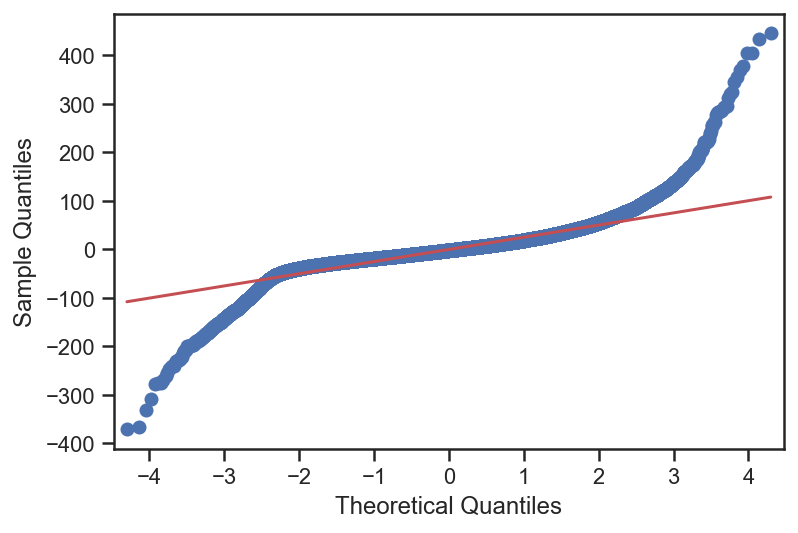

In [15]:
fig = sm.qqplot(lm5.resid, line='s') # residual QQ plot
plt.show()

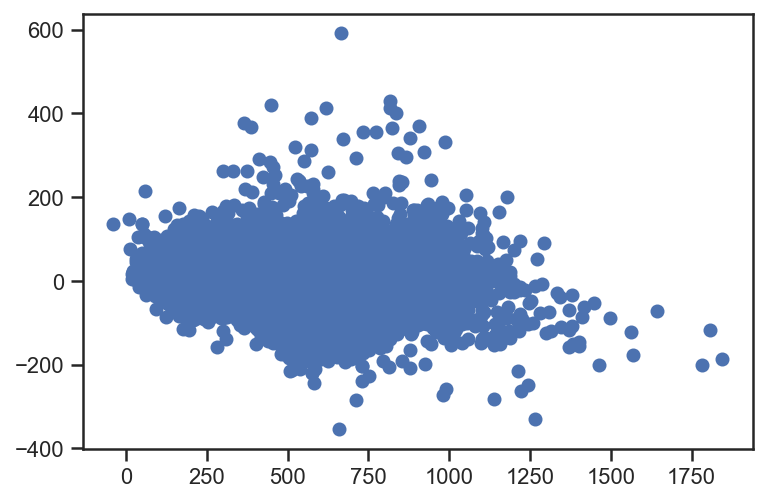

In [16]:
res_plot = plt.scatter(lm4.fittedvalues, lm4.resid)